### Imports and Common Functions

In [1]:
%matplotlib inline

import os

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import LineString

def build_to_points(group):
    group = group.sort_values('shape_pt_sequence')
    group['to_point_lon'] = group.shift(1)['from_point_lon']
    group['to_point_lat'] = group.shift(1)['from_point_lat']
    return group

def build_lines(row):
    return LineString([(row['from_point_lon'], row['from_point_lat']), (row['to_point_lon'], row['to_point_lat'])])

### Setup the Folders and Network

In [2]:
HOME_DIR = os.path.join(os.getcwd(), '..', "fasttrips", "Examples", )
NETWORK_HOME_DIR = os.path.join(HOME_DIR, 'networks', 'psrc_1_1')

## Fast Trips Method
Calculate the Distance and Geometry from the stops.txt and stop_times.txt file
This results in straight line distances between stops and underestimates distance traveled.

In [3]:
stops_df = pd.read_csv(os.path.join(NETWORK_HOME_DIR, 'stops.txt'), usecols=['stop_id','stop_lon', 'stop_lat',])
stop_times_df = pd.read_csv(os.path.join(NETWORK_HOME_DIR, 'stop_times.txt'), usecols=['trip_id','stop_id', 'stop_sequence'])

trips_df = pd.merge(stops_df, stop_times_df, on='stop_id')
trips_df.rename(columns={'stop_lat': 'from_point_lat', 'stop_lon': 'from_point_lon', 'stop_sequence': 'shape_pt_sequence'}, inplace=True)
trips_df = trips_df.groupby(['trip_id'], group_keys=False).apply(build_to_points)
geometry = [LineString([(x1,y1), (x2,y2)]) for x1,y1,x2,y2 in zip(trips_df.from_point_lon, trips_df.from_point_lat, trips_df.to_point_lon, trips_df.to_point_lat)]
crs = {'init': 'epsg:4326'}
geo_trips_df = gpd.GeoDataFrame(trips_df, crs=crs, geometry=geometry)

## GTFS Shape Method
Calculate the Distance and Geometry from the shapes.txt file
This results (when available) in the full route line distances between stops and calculates more realistic distance traveled.

In [4]:
shapes_df = pd.read_csv(os.path.join(NETWORK_HOME_DIR, 'shapes.txt'), usecols=['shape_id','shape_pt_lon', 'shape_pt_lat','shape_pt_sequence'])
shapes_df.rename(columns={'shape_pt_lat': 'from_point_lat', 'shape_pt_lon': 'from_point_lon'}, inplace=True)

shapes_df = shapes_df.groupby(['shape_id'], group_keys=False).apply(build_to_points)
geometry = [LineString([(x1,y1), (x2,y2)]) for x1,y1,x2,y2 in zip(shapes_df.from_point_lon, shapes_df.from_point_lat, shapes_df.to_point_lon, shapes_df.to_point_lat)]
crs = {'init': 'epsg:4326'}
geo_shapes_df = gpd.GeoDataFrame(shapes_df, crs=crs, geometry=geometry)

## Showcase the Difference
Orange = Fast Trips  
Black = GTFS

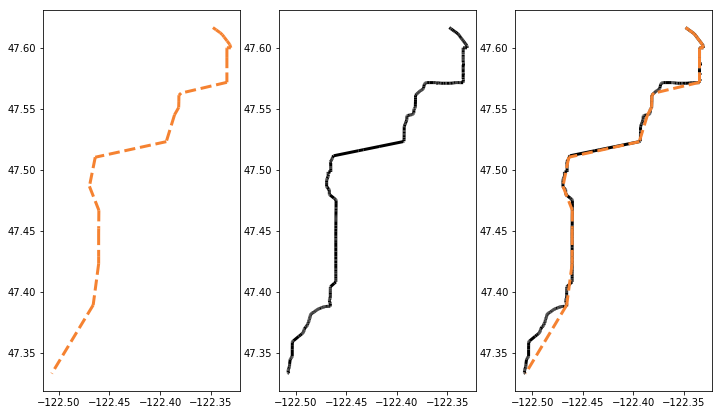

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12,7))
geo_trips_df[geo_trips_df.trip_id == 1921].plot(ax=ax[0], color='#f58231', linestyle='--', linewidth=3)
geo_shapes_df[geo_shapes_df.shape_id == 110289].plot(ax=ax[1], color='black',linewidth=3)

geo_shapes_df[geo_shapes_df.shape_id == 110289].plot(ax=ax[2], color='black', linewidth=3)
geo_trips_df[geo_trips_df.trip_id == 1921].plot(ax=ax[2], color='#f58231', linestyle='--', linewidth=3)

## Showcase the Difference
Orange = Fast Trips  
Black = GTFS

In [1]:
def shape_style(feature):
    return {
        'color': '#000000',
        'weight': 8
    }

def stop_style(feature):
    return {
        'color': '#f58231',
        'weight': 6
    }

m  = folium.Map([47.5, -122.425], tiles='Stamen Terrain', zoom_start=10)
folium.GeoJson(
    geo_shapes_df[geo_shapes_df.shape_id == 110289][1:].to_json(),
    style_function = shape_style,    
).add_to(m)

folium.GeoJson(
    geo_trips_df[geo_trips_df.trip_id == 1921][1:].to_json(),
    style_function = stop_style
).add_to(m)

m

NameError: name 'folium' is not defined